# Feature Study on Speech Signal Part 1 - Feature Engineering and Feature Importance Analysis

This notebook focuses on extracting and analyzing signal features essential for building an efficient and accurate emotion/sentiment analysis model.

Actions:  
[x] To extract meaningful features from audio signals, including prosodic and time-frequency domain features.  
[x] To evaluate the significance of these features using feature importance metrics to optimize the model’s performance.  

In [1]:
import librosa
import librosa.display
from librosa.core import load
import numpy as np
import pandas as pd
import glob
import os, sys
import matplotlib.pyplot as plt

In [2]:
master_data = pd.read_csv('./dataset_info_combined_V4.csv')
# labels = master_data[master_data.dataset_name=='RAVDESS'][['file_path','emotional_category']]
#labels.shape #(1440, 2)

### Data Loading

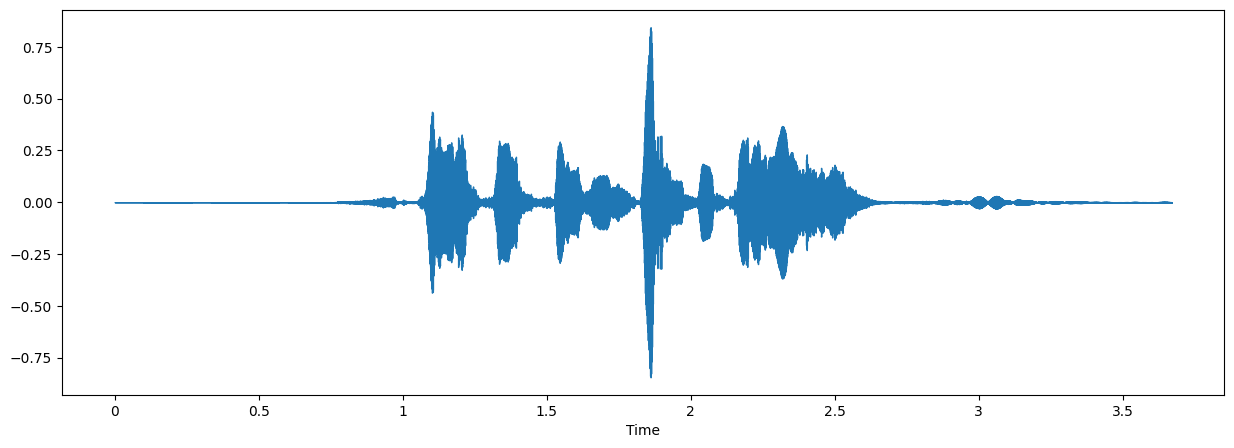

In [3]:
data, sampling_rate = librosa.load('./dataset/RAVDESS/Actor_12/03-01-06-02-02-02-12.wav')

%matplotlib inline
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

/var/folders/jv/1vv6tgys3bzf7drmcnhh7q2m0000gn/T/ipykernel_40795/1455000516.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr,x = scipy.io.wavfile.read('./dataset/RAVDESS/Actor_12/03-01-06-02-02-02-12.wav')
/var/folders/jv/1vv6tgys3bzf7drmcnhh7q2m0000gn/T/ipykernel_40795/1455000516.py:13: RuntimeWarning: divide by zero encountered in log
  X[i,:] = np.log(np.abs(z[:nfft//2]))


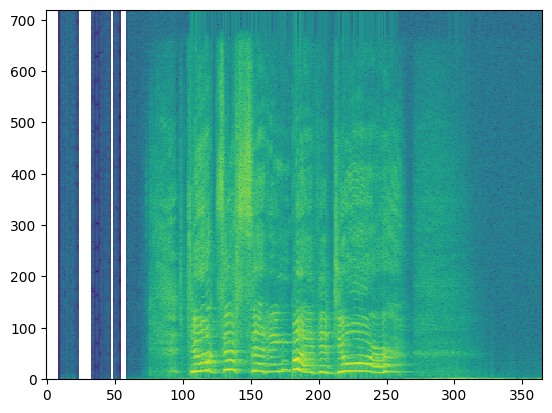

In [4]:
import scipy.io.wavfile
sr,x = scipy.io.wavfile.read('./dataset/RAVDESS/Actor_12/03-01-06-02-02-02-12.wav')
## 参数: 10ms一步, 30ms窗长
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin
window = np.hamming(nwin)
nn = range(nwin, len(x), nstep)
X = np.zeros( (len(nn), nfft//2) )
for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))
plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')
plt.show()

### Data prcessing and feature engineering
remove silence
```
filename = './dataset/RAVDESS/Actor_12/03-01-06-02-02-02-12.wav'
sample_rate_raw = librosa.get_samplerate(filename)
duration = round(librosa.get_duration(path=filename),2)
trimmed_X, _ = librosa.effects.trim(X)
```

### Spectogram - Time-Frequency 2D representation Feature
Step 1, Windowing: Signal broken into (non)overlapping short-term windows  
Step 2, FFT: Fast Implementation of the Discrete Fourier Transform (DFT)

input X shape                : (duration_in_seconds * sample_rate)  
output mel spectrogram shape : (n_mels=n_fft//2+1, t=n_frames=input.length/hop_length) 
```
X_stft = librosa.stft(X)
Xdb = librosa.amplitude_to_db(abs(X_stft))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()
```

In [4]:
filename = './dataset/RAVDESS/Actor_12/03-01-06-02-02-02-12.wav'
sample_rate_set = 16000
X, sample_rate = librosa.load(filename, res_type='kaiser_fast',duration=2.5,sr=16000,offset=0.5)
mel = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_fft=2048, hop_length=512,
                                     n_mels=128, fmax=8000)
print(f"input X shape {X.shape} and sample rate: {sample_rate}" )
print("mel spectrograme shape:" , mel.shape)
feature_mel = np.mean(mel.T, axis=0)

input X shape (40000,) and sample rate: 16000
mel spectrograme shape: (128, 79)


In [5]:
def get_stats_from_feature(feature_input):
    '''return mean, median, std 90% min max''' 
    feature_mean = np.mean(feature_input.T, axis=0)
    feature_median = np.median(feature_input.T, axis=0)
    feature_std  = np.std(feature_input.T, axis=0)
    feature_p10, feature_p90  = np.percentile(feature_input.T, 10, axis=0), np.percentile(feature_input.T, 90, axis=0)
    return np.concatenate((feature_mean,feature_median,feature_std, feature_p10, feature_p90), axis=0)

In [6]:
feature_mel_stats = get_stats_from_feature(mel).reshape(128,5)
feature_mel_stats.shape

(128, 5)

In [7]:
feature_mel_stats_df = pd.DataFrame(feature_mel_stats,
                                    columns=['mean','median','std','min','max'])

In [8]:
feature_mel_stats_df.corr().round(3)

,mean,median,std,min,max
mean,1.000,0.884,0.684,0.471,0.266
median,0.884,1.000,0.916,0.529,0.268
std,0.684,0.916,1.000,0.695,0.385
min,0.471,0.529,0.695,1.000,0.853
max,0.266,0.268,0.385,0.853,1.000


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

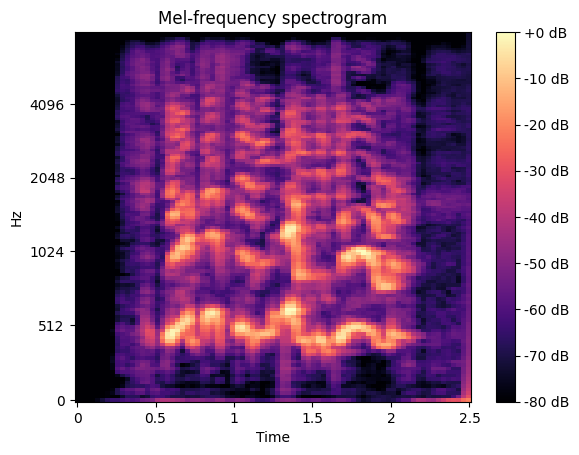

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(mel, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sample_rate, fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

### Mel-Frequency Cepstral Coefficients (MFCC)
• Compute Fourier transform  
• Apply Mel-scale filter bank  
• Compute the power of the output of each filter  
• Compute MFCCs as the Fourier transform coefficients of the mel-scaled log-power spectrum  
• Usually select the first 13 MFCCs (considered to carry sufficient discriminative information for audio analytics). 
There are 13 MFCC values per segment.  
```
X, sample_rate = librosa.load(filename, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
mfccs = librosa.feature.mfcc(y=X, sr=np.array(sample_rate), n_mfcc=13)
```

In [12]:
mfccs_40 = librosa.feature.mfcc(y=X, sr=np.array(sample_rate), n_mfcc=40)
feature_mfcc_40 = np.mean(mfccs_40.T, axis=0)
mfccs_20 = librosa.feature.mfcc(y=X, sr=np.array(sample_rate), n_mfcc=20)
feature_mfcc_20 = np.mean(mfccs_20.T, axis=0)
feature_mfcc_20, feature_mfcc_40

(array([-339.4076   ,   36.003307 ,  -54.830734 ,   -1.4321157,
         -29.391483 ,   -6.8107615,  -27.72864  ,  -21.13494  ,
         -14.007693 ,   -6.015982 ,  -10.898997 ,   15.231565 ,
          15.0613785,   28.51994  ,    2.4520676,   10.033701 ,
          -5.6154747,   -0.8110706,   -2.6483552,    1.5716243],
       dtype=float32),
 array([-3.39407593e+02,  3.60033073e+01, -5.48307343e+01, -1.43211567e+00,
        -2.93914833e+01, -6.81076145e+00, -2.77286396e+01, -2.11349392e+01,
        -1.40076933e+01, -6.01598215e+00, -1.08989973e+01,  1.52315655e+01,
         1.50613785e+01,  2.85199394e+01,  2.45206761e+00,  1.00337009e+01,
        -5.61547470e+00, -8.11070621e-01, -2.64835525e+00,  1.57162428e+00,
        -4.59322214e+00, -8.86617422e-01, -6.45877361e+00,  3.88946295e+00,
         1.50164521e+00,  5.72512388e+00,  7.80182505e+00,  6.29318666e+00,
         1.16454494e+00,  6.25079727e+00,  3.88098264e+00,  3.25530744e+00,
         2.89266324e+00, -1.97661889e+00, -3.345

In [15]:
feature_mfcc_stats = get_stats_from_feature(mfccs_20).reshape(20,5)
pd.DataFrame(feature_mfcc_stats,columns=['mean','median','std','min','max']).corr().round(3)

,mean,median,std,min,max
mean,1.000,-0.222,0.838,0.394,0.786
median,-0.222,1.000,0.324,0.736,0.358
std,0.838,0.324,1.000,0.806,0.951
min,0.394,0.736,0.806,1.000,0.783
max,0.786,0.358,0.951,0.783,1.000


#### relationship from STFT, Mel Spectogram, filter bank and MFCC
![image.png](https://res.cloudinary.com/practicaldev/image/fetch/s--E164iWYi--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://dev-to-uploads.s3.amazonaws.com/uploads/articles/77itb11zc9r0e2p1pepb.png)

### processing magnitude-scaling
https://librosa.org/doc/main/core.html#magnitude-scaling
librosa.amplitude_to_db， power_to_db perceptual_weighting

### zero crossing rate
The zero-crossing rate (ZCR) is **the rate at which a signal changes from positive to zero to negative or from negative to zero to positive**. Its value has been widely used in both speech recognition and music information retrieval, being a key feature to classify percussive sounds. is an indicator function.  

output zcr shape : (1, t=n_frames=input.length/hop_length) 
```
feature_zcr  = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0)
```

zcr shape: (1, 79)


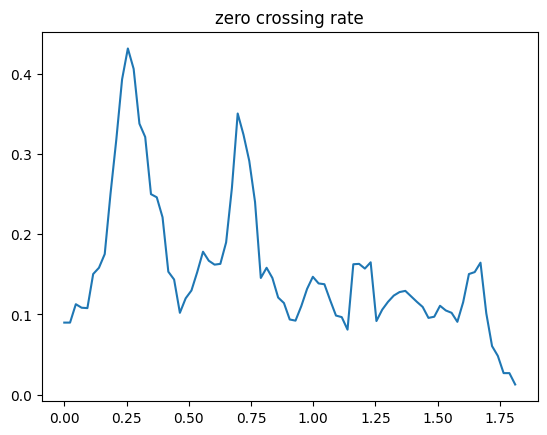

In [16]:
zcr   = librosa.feature.zero_crossing_rate(y=X)
print("zcr shape:" ,zcr.shape)
frame_scale = np.arange(0,79,step=1)
time_scale = librosa.frames_to_time(frame_scale, hop_length=512)
plt.plot(time_scale, zcr.T)
plt.title("zero crossing rate")

feature_zcr  = np.mean(zcr.T, axis=0)

### reverse back audio signal from spectrogram
**GPT Answer:** 
Yes, you can potentially reconstruct an audio signal from its spectrogram, but it's not a straightforward process and may not yield an exact replica of the original audio signal due to information loss during the transformation to the spectrogram.

Here's a high-level overview of how you might approach this:

Inverse Short-Time Fourier Transform (ISTFT): The spectrogram is usually computed using Short-Time Fourier Transform (STFT). To reverse this process, you need to perform an Inverse Short-Time Fourier Transform (ISTFT). ISTFT takes the magnitude and phase information from the spectrogram to reconstruct the time-domain signal.
Phase Reconstruction: Simply using the magnitude information from the spectrogram for reconstruction might result in a noisy or distorted audio signal. Therefore, it's crucial to also incorporate phase information during the reconstruction process. Techniques such as Griffin-Lim algorithm or phase vocoder can be used for phase reconstruction.
Window Function: During the STFT, the signal is divided into overlapping segments with a window function applied to each segment. When reconstructing the signal, you need to carefully handle the windowing to avoid artifacts like amplitude modulation.
Magnitude and Phase Consistency: Ensuring consistency between the reconstructed magnitude and phase spectra is important for generating a realistic audio signal. Techniques such as spectrogram inversion with phase estimation (SIPE) aim to achieve this consistency.
```
# Load the spectrogram
spec = np.abs(librosa.stft(y))

# Reconstruct the signal using ISTFT
y_reconstructed = librosa.istft(spec)

# Save the reconstructed signal as a wav file
librosa.output.write_wav('reconstructed_signal.wav', y_reconstructed, sr)
```

### Combined five types of features

### feature extraction reference
Link: https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition
```
def extract_features(data):
    # ZCR: zero crossing rate (1)
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally
    # Chroma_stft 12
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 
    # MFCC 20
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 
    # Root Mean Square Value (1) 
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) 
    # MelSpectogram (128,)
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))
    return result
```

In [17]:
def get_stats_from_feature(feature_input):
    feature_mean,feature_std  = np.mean(feature_input.T, axis=0),np.std(feature_input.T, axis=0)
    feature_p10, feature_p90  = np.percentile(feature_input.T, 10, axis=0), np.percentile(feature_input.T, 90, axis=0)
    return np.concatenate((feature_mean,feature_std, feature_p10, feature_p90), axis=0)

In [18]:
filename_list = master_data[master_data.dataset_name=='RAVDESS'].file_path.tolist()
from librosa.core import load
df = pd.DataFrame(columns=['feature'])
bookmark=0
sample_rate_set = 16000
for index,filename in enumerate(filename_list):
    X, sample_rate = librosa.load(filename, res_type='kaiser_fast',duration=2.5,sr=sample_rate_set,offset=0.5)
    mfccs = librosa.feature.mfcc(y=X, sr=np.array(sample_rate), n_mfcc=40)
    feature_mfcc = np.mean(mfccs.T, axis=0)
    stft = np.abs(librosa.stft(X))
    feature_chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    feature_mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate,
                                                         n_fft=2048, hop_length=512,
                                                         n_mels=128, fmax=8000).T, axis=0)
    
    feature_zcr_full  = librosa.feature.zero_crossing_rate(y=X)
    feature_rms_full = librosa.feature.rms(y=X)
    feature_zcr_stats = get_stats_from_feature(feature_zcr_full)
    feature_rms_stats = get_stats_from_feature(feature_rms_full)
    
    feature  = np.concatenate((feature_mfcc,feature_chroma_stft,feature_mel,
                               feature_zcr_full.reshape(-1,),feature_rms_full.reshape(-1,),
                               feature_zcr_stats,feature_rms_stats
                              ), axis=0)
    df.loc[bookmark] = [feature]
    bookmark=bookmark+1

In [19]:
prefixes = {'mfcc': 40,'chroma': 12, 'mel': 128, 'zcr':79, 'rms':79 }
column_names = []
for prefix, num_features in prefixes.items():
    column_names.extend([f'{prefix}_{i}' for i in range(1, num_features + 1)])
other_features = ['zcr_mean','zcr_std','zcr_p10','zcr_p90','rms_mean','rms_std','rms_p10','rms_p90']
column_names.extend(other_features)
# print(column_names)

In [20]:
df_feat = pd.DataFrame(df['feature'].values.tolist())
df_feat.columns = column_names
df_joint = pd.concat([df_feat,master_data[master_data.dataset_name=='RAVDESS'][['file_path','emotional_category']].emotional_category.reset_index(drop=True)], axis=1)
df_joint = df_joint.rename(index=str, columns={"emotional_category": "label"})
# df_joint

### Feature Importance Analysis

In [24]:
df_joint = df_joint.dropna(how='any')
X = df_joint.drop('label', axis=1)
y = df_joint['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       Anger       0.57      0.68      0.62        37
    Calmness       0.33      0.27      0.30        37
     Disgust       0.42      0.34      0.37        44
        Fear       0.31      0.33      0.32        39
   Happiness       0.27      0.25      0.26        36
  Neutrality       0.08      0.11      0.09        19
     Sadness       0.17      0.21      0.18        39
    Surprise       0.32      0.27      0.29        37

    accuracy                           0.32       288
   macro avg       0.31      0.31      0.31       288
weighted avg       0.32      0.32      0.32       288



              precision    recall  f1-score   support

       Anger       0.67      0.54      0.60        37
    Calmness       0.53      0.70      0.60        37
     Disgust       0.74      0.66      0.70        44
        Fear       0.53      0.51      0.52        39
   Happiness       0.46      0.47      0.47        36
  Neutrality       0.64      0.37      0.47        19
     Sadness       0.39      0.41      0.40        39
    Surprise       0.47      0.54      0.50        37

    accuracy                           0.54       288
   macro avg       0.55      0.53      0.53       288
weighted avg       0.55      0.54      0.54       288

[[20  0  3  1  6  0  1  6]
 [ 0 26  2  1  0  2  6  0]
 [ 4  5 29  2  1  0  3  0]
 [ 2  0  0 20  4  1  8  4]
 [ 3  0  3  6 17  0  1  6]
 [ 0  5  0  1  0  7  5  1]
 [ 0 11  0  4  2  0 16  6]
 [ 1  2  2  3  7  1  1 20]]


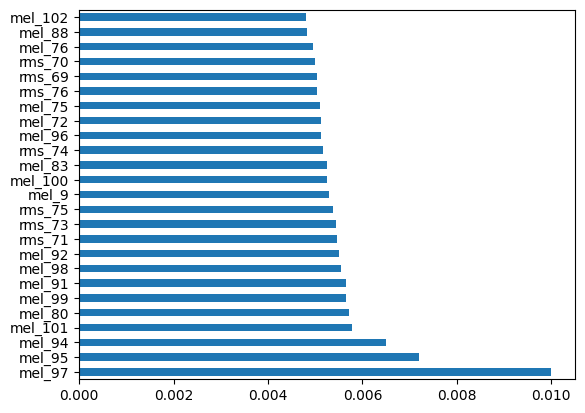

In [26]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize a Random Forest classifier
clf = RandomForestClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
predictions = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

# Visualize feature importances
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.nlargest(25).plot(kind='barh')
plt.show()